# Facial Verification using Siamese Network

## Setup

### Import Dependencies

In [8]:
# import standard dependiencies
import cv2 as cv
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [9]:
# import tensorflow dependencies
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate, Layer

In [30]:
# Model(inputs=[inputimage, verificationimage], outputs=[[1,0]])

### Create Folder Structure

In [10]:
# setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [11]:
# make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## Collect positives and anchors

### Untar labeled images faces in wild dataset

In [12]:
# uncompress the tar gz dataset
!tar -xzvf lfw.tgz

x lfw/
x lfw/George_HW_Bush/
x lfw/George_HW_Bush/George_HW_Bush_0001.jpg
x lfw/George_HW_Bush/George_HW_Bush_0002.jpg
x lfw/George_HW_Bush/George_HW_Bush_0003.jpg
x lfw/George_HW_Bush/George_HW_Bush_0004.jpg
x lfw/George_HW_Bush/George_HW_Bush_0005.jpg
x lfw/George_HW_Bush/George_HW_Bush_0006.jpg
x lfw/George_HW_Bush/George_HW_Bush_0007.jpg
x lfw/George_HW_Bush/George_HW_Bush_0008.jpg
x lfw/George_HW_Bush/George_HW_Bush_0009.jpg
x lfw/George_HW_Bush/George_HW_Bush_0010.jpg
x lfw/George_HW_Bush/George_HW_Bush_0011.jpg
x lfw/George_HW_Bush/George_HW_Bush_0012.jpg
x lfw/George_HW_Bush/George_HW_Bush_0013.jpg
x lfw/Curtis_Strange/
x lfw/Curtis_Strange/Curtis_Strange_0001.jpg
x lfw/Marc_Grossman/
x lfw/Marc_Grossman/Marc_Grossman_0001.jpg
x lfw/Marc_Grossman/Marc_Grossman_0002.jpg
x lfw/Marc_Grossman/Marc_Grossman_0003.jpg
x lfw/Marc_Grossman/Marc_Grossman_0004.jpg
x lfw/Michael_Schumacher/
x lfw/Michael_Schumacher/Michael_Schumacher_0001.jpg
x lfw/Michael_Schumacher/Michael_Schumacher_000

In [5]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collect positive and anchor classes

In [6]:
# Import uuid to generate unique names for the images
import uuid

In [13]:
cap = cv.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # cut frame to 250x250px
    frame = frame[130:130+250, 200:200+250, :]
    
    # collect positive images
    if cv.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))  
        cv.imwrite(imgname, frame)
    # Collect anchor images
    if cv.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))  
        cv.imwrite(imgname, frame)
        
    cv.imshow('Image Collection', frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

## Load and Preprocess images

### Get image paths

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

### Preprocess images - Scale and Resize

In [15]:
def preprocess(file_path):
    # Read in image from file_path
    byte_img = tf.io.read_file(file_path)
    # Load image as a tensor
    img = tf.io.decode_jpeg(byte_img)
    
    # preprocess image - Resizing image to 100x100x3
    img = tf.image.resize(img, (100,100))
    # Normalize image - Scaling image to [0,1]
    img = img/255.0
    return img

### Create Labelled Dataset

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()
example = samples.next()

### Build Train and Test partitions

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

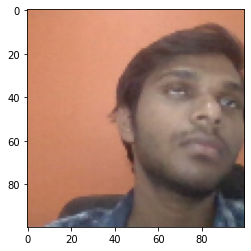

In [19]:
res = preprocess_twin(*example)
plt.imshow(res[0])

In [30]:
# Build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [58]:
# Training Partition
train_data = data.take(round(len(data)*0.7))
train_data =  train_data.batch(16)
train_data = train_data.prefetch(8) 

In [59]:
# Testing Partition

test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data =  test_data.batch(16)
test_data = test_data.prefetch(8) 